# Overdispersed Binomial distribution

This notebook examines properties of `pyro.contrib.epidemiology`'s overdispersed distribution
```py
binomial_dist(n, p, overdispersion=...)
```

## Derivation

In [1]:
import torch
from torch.distributions.transforms import SigmoidTransform
import pyro.distributions as dist
import matplotlib.pyplot as plt
torch.set_default_dtype(torch.double)

In [2]:
def overdispersed_binomial(total_count, probs, overdispersion):
    p = probs
    q = 1 - p
    concentration = 1 / (p * q * overdispersion**2) - 1
    c1 = concentration * p
    c0 = concentration * q
    return dist.BetaBinomial(c1, c0, total_count)

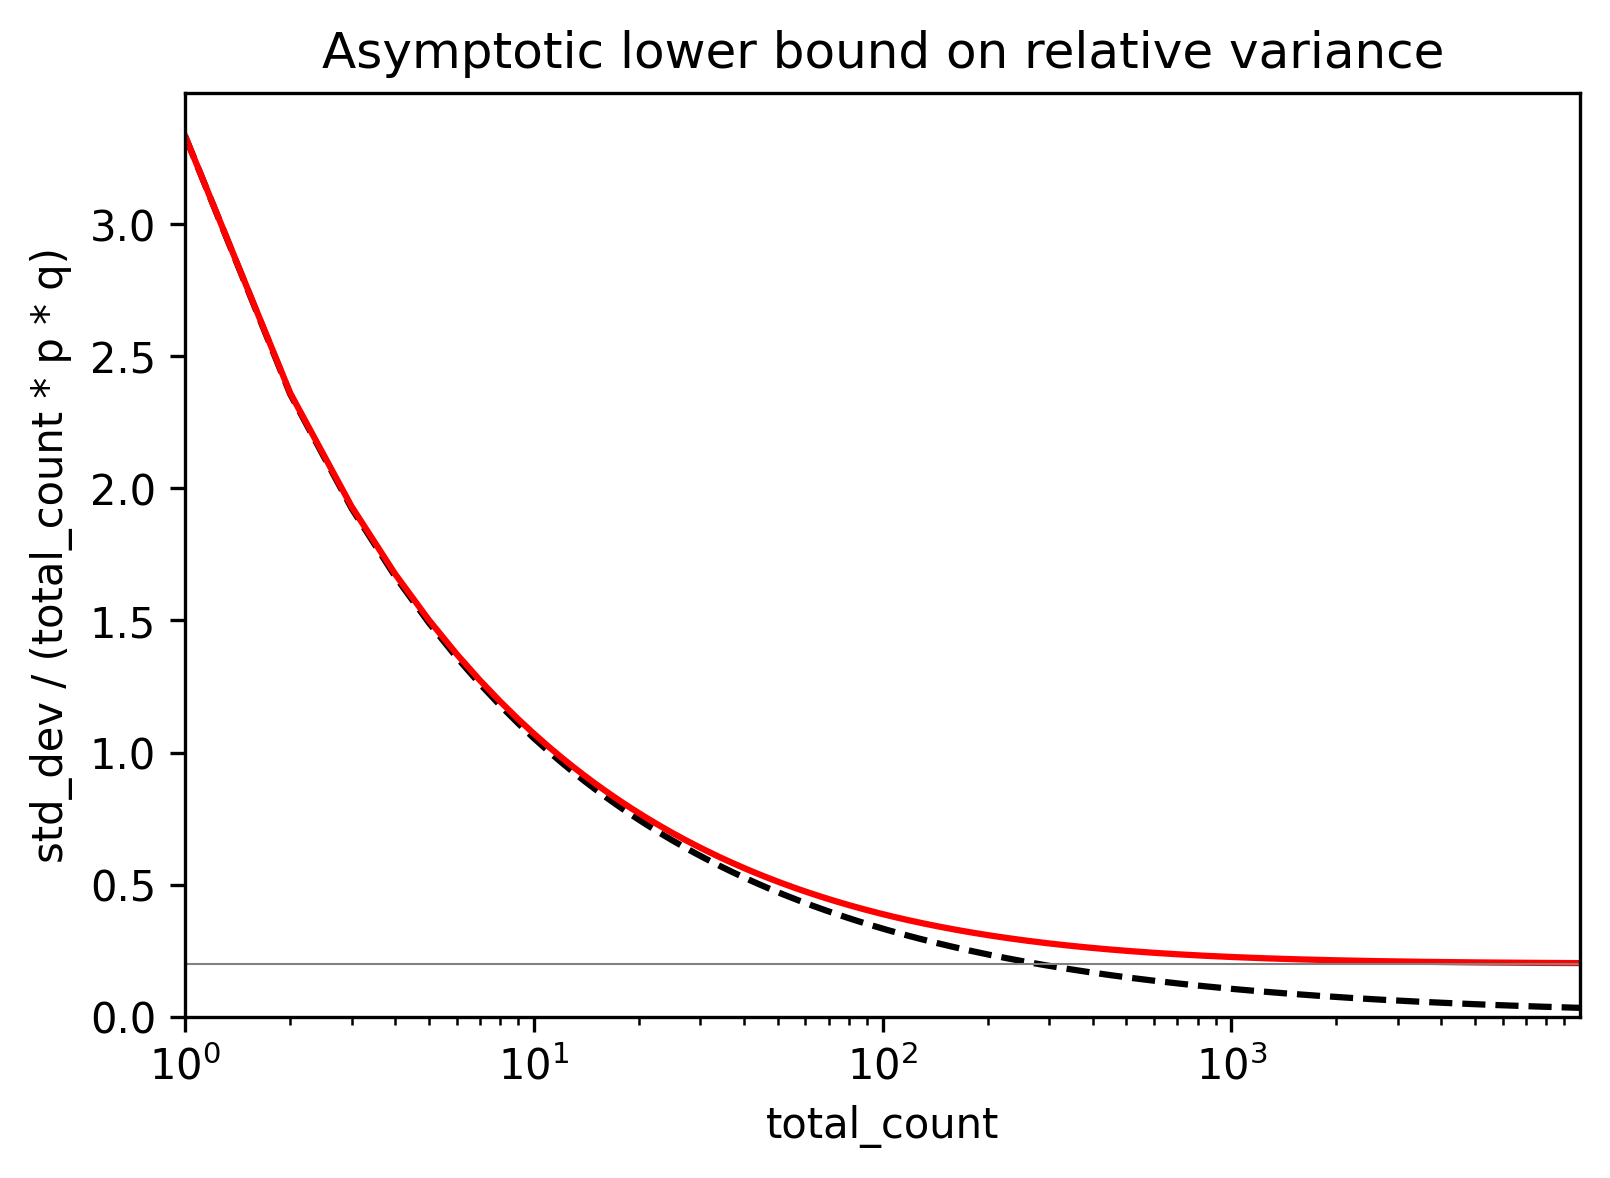

In [3]:
def plot_asymptote(o, p, ax=None):
    total_count = torch.arange(1, 10000.)
    q = 1 - p
    d1 = dist.Binomial(total_count, p)
    d2 = overdispersed_binomial(total_count, p, o)
    re1 = d1.variance.sqrt() / (total_count * p * q)
    re2 = d2.variance.sqrt() / (total_count * p * q)
    
    if ax is None:
        ax = plt.gca()
    ax.plot(total_count, re1, 'k--')
    ax.plot(total_count, re2, 'r-')
    ax.axhline(o, color='0.5', lw=0.5)
    ax.set_xscale("log")
    ax.set_ylim(0, None)
    ax.set_xlim(1, total_count.max())

plt.figure(figsize=(6, 4), dpi=300).patch.set_color("white")
plot_asymptote(o=0.2, p=0.1)
plt.xlabel("total_count")
plt.ylabel("std_dev / (total_count * p * q)")
plt.title("Asymptotic lower bound on relative variance");

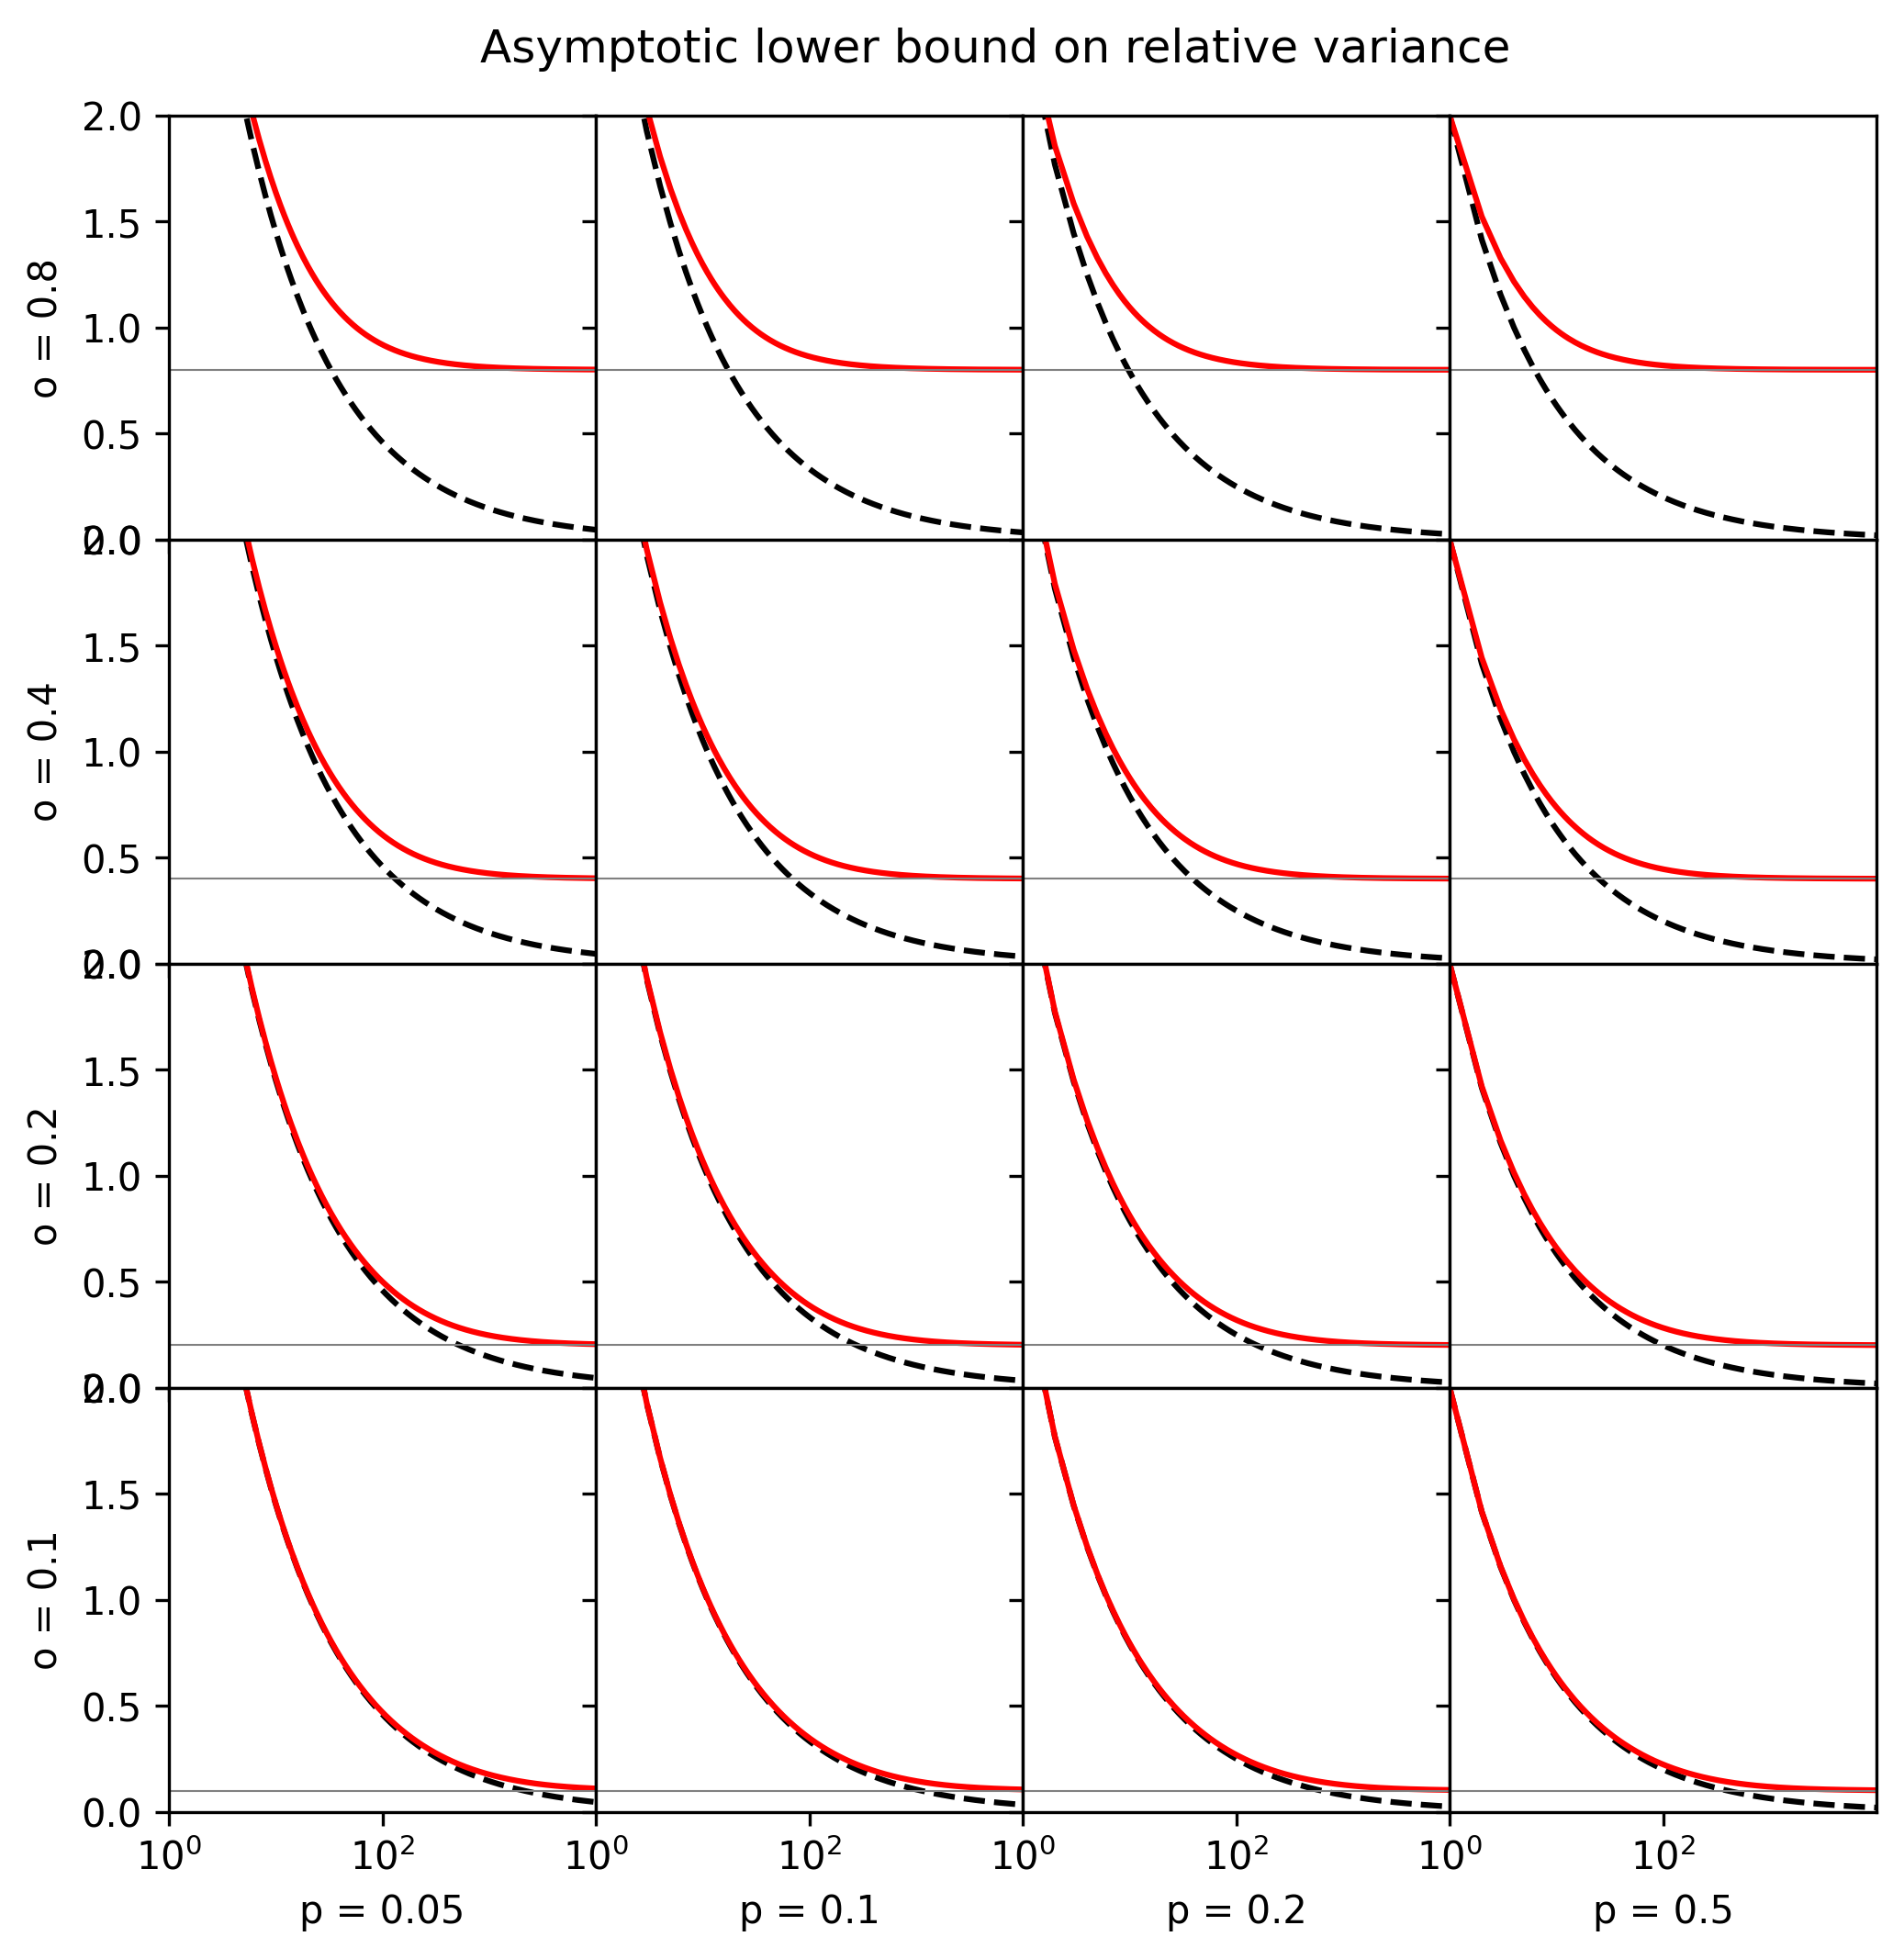

In [4]:
o_grid = [0.8, 0.4, 0.2, 0.1]
p_grid = [0.05, 0.1, 0.2, 0.5]
fig, axes = plt.subplots(len(o_grid), len(p_grid), figsize=(8,8),
                         sharex=True, sharey="row", dpi=300)
fig.patch.set_color("white")
for i, o in enumerate(o_grid):
    for j, p in enumerate(p_grid):
        ax = axes[i][j]
        plot_asymptote(o, p, ax)
        ax.set_ylim(0, 2)
        if i == len(o_grid) - 1:
            ax.set_xlabel("p = {}".format(p))
        if j == 0:
            ax.set_ylabel("o = {}".format(o))
plt.subplots_adjust(wspace=0, hspace=0)
fig.suptitle("Asymptotic lower bound on relative variance", y=0.92);

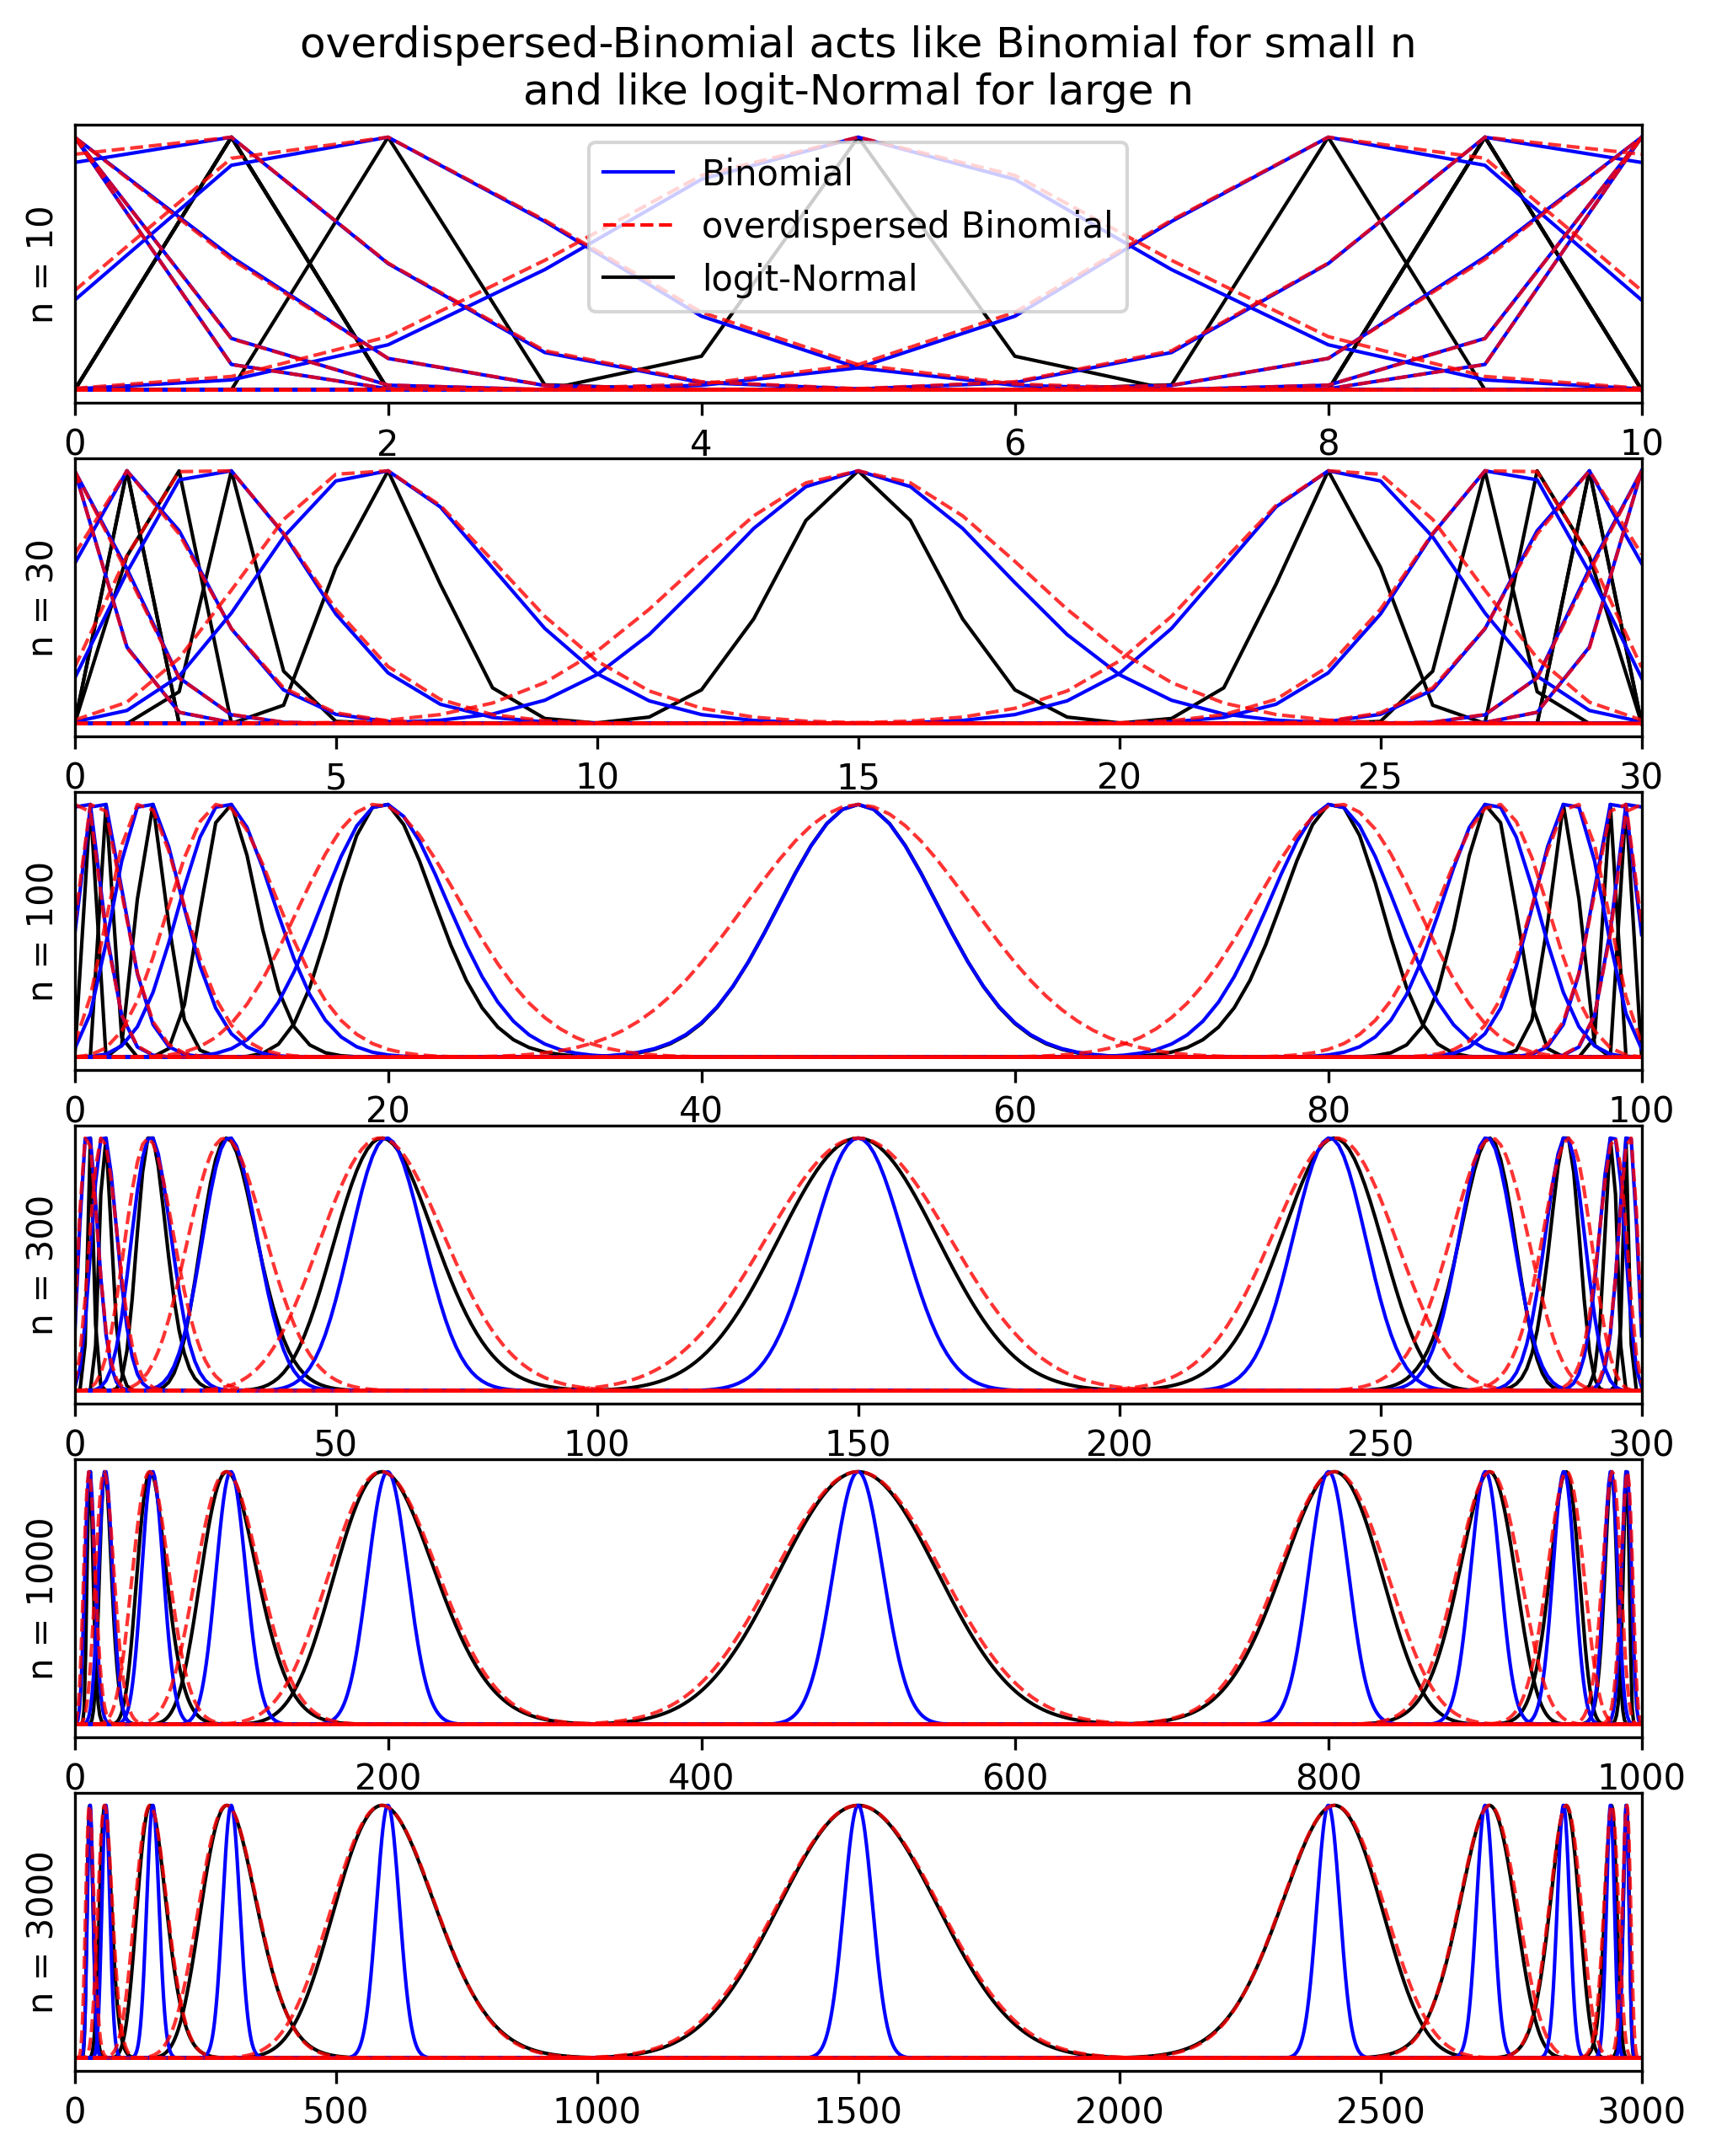

In [5]:
total_counts = [10, 30, 100, 300, 1000, 3000]
p = torch.tensor([0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 0.8, 0.9, 0.95, 0.98, 0.99])
q = 1 - p
o = 0.2

fig, axes = plt.subplots(len(total_counts), figsize=(8, 10), dpi=300)
fig.patch.set_color("white")
for n, ax in zip(total_counts, axes):
    k = torch.arange(0., n + 1.).unsqueeze(-1)
    p1 = dist.Binomial(n, p).log_prob(k).exp()
    p2 = overdispersed_binomial(n, p, o).log_prob(k).exp()
    d3 = dist.TransformedDistribution(dist.Normal((p/(1-p)).log(), o), SigmoidTransform())
    p3 = d3.log_prob(k / n).exp() / n
    ax.plot(p3 / p3.max(0).values, "k-", lw=1)
    ax.plot(p1 / p1.max(0).values, "b-", lw=1)
    ax.plot(p2 / p2.max(0).values, "r--", lw=1, alpha=0.8)
    ax.set_xlim(0, n)
    ax.set_yticks(())
    ax.set_ylabel("n = {}".format(n))
axes[0].plot([], "b-", lw=1, label="Binomial")
axes[0].plot([], "r--", lw=1, label="overdispersed Binomial")
axes[0].plot([], "k-", lw=1, label="logit-Normal")
axes[0].legend(loc="upper center")
axes[0].set_title("overdispersed-Binomial acts like Binomial for small n\n"
                  "and like logit-Normal for large n");

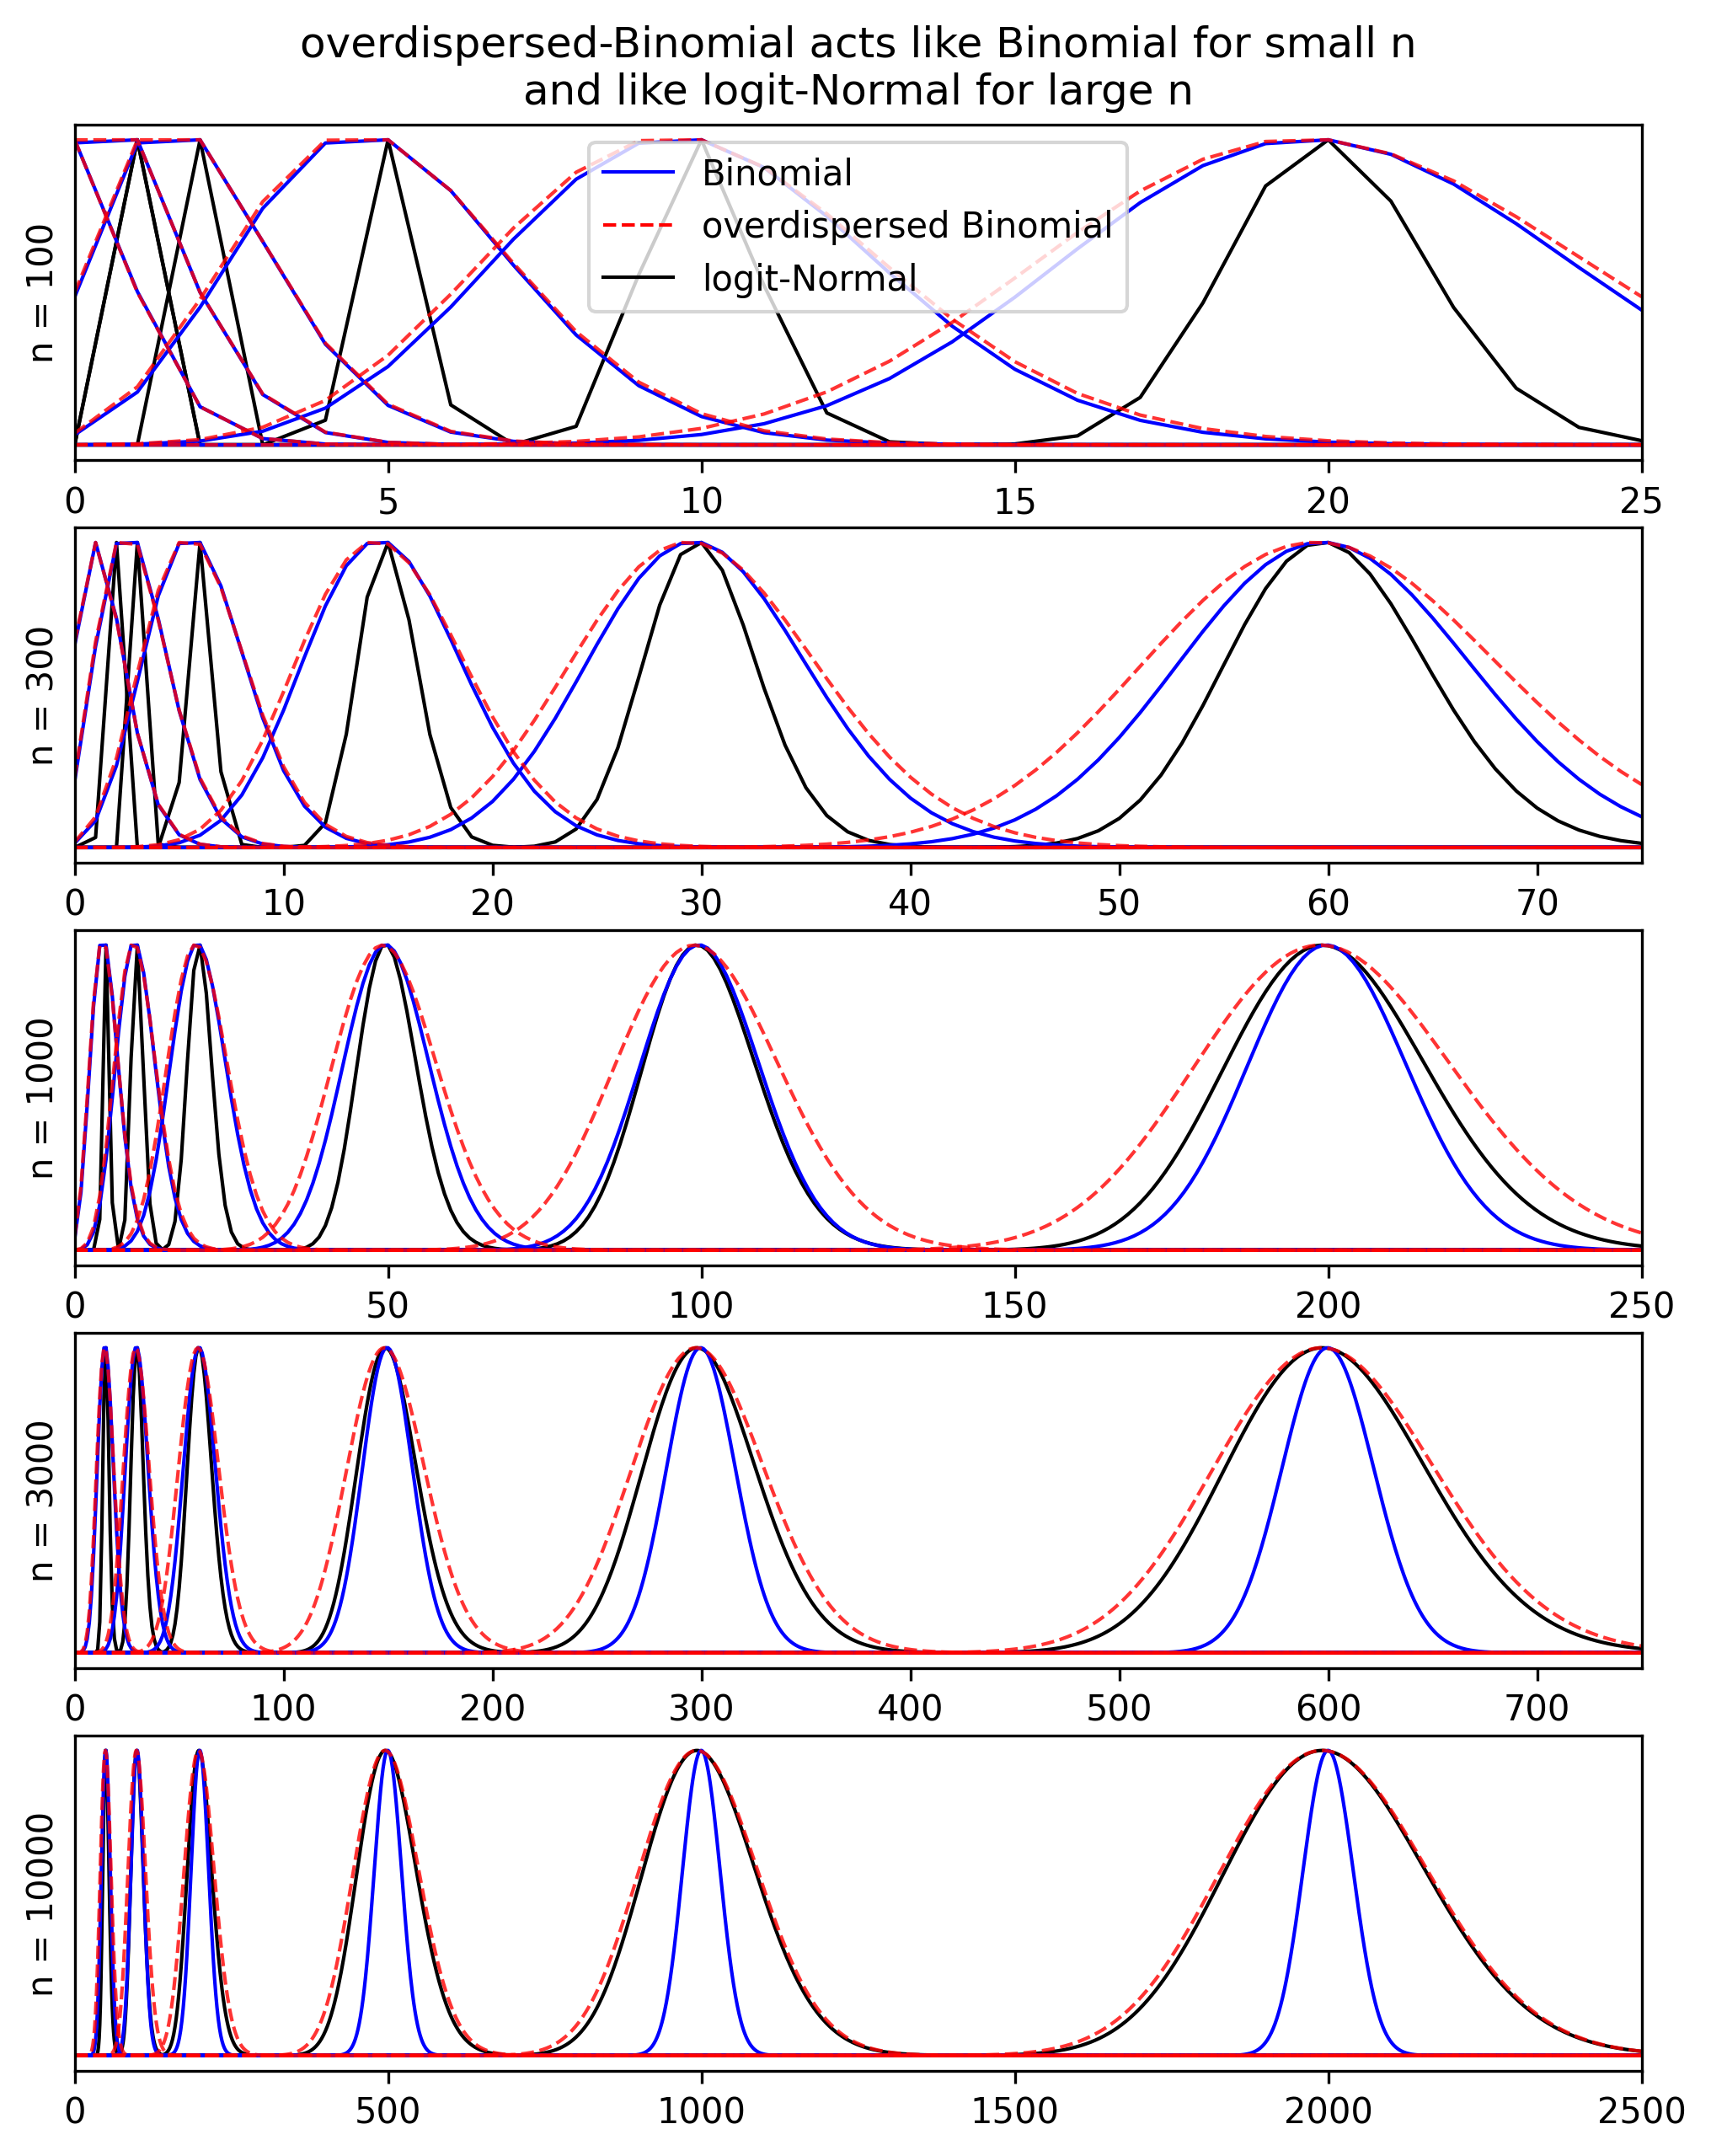

In [6]:
total_counts = [100, 300, 1000, 3000, 10000]
p = torch.tensor([0.005, 0.01, 0.02, 0.05, 0.1, 0.2])
q = 1 - p
o = 0.1

fig, axes = plt.subplots(len(total_counts), figsize=(8, 10), dpi=300)
fig.patch.set_color("white")
for n, ax in zip(total_counts, axes):
    k = torch.arange(0., n // 4 + 1.).unsqueeze(-1)
    p1 = dist.Binomial(n, p).log_prob(k).exp()
    p2 = overdispersed_binomial(n, p, o).log_prob(k).exp()
    d3 = dist.TransformedDistribution(dist.Normal((p/(1-p)).log(), o), SigmoidTransform())
    p3 = d3.log_prob(k / n).exp() / n
    ax.plot(p3 / p3.max(0).values, "k-", lw=1)
    ax.plot(p1 / p1.max(0).values, "b-", lw=1)
    ax.plot(p2 / p2.max(0).values, "r--", lw=1, alpha=0.8)
    ax.set_xlim(0, n / 4)
    ax.set_yticks(())
    ax.set_ylabel("n = {}".format(n))
axes[0].plot([], "b-", lw=1, label="Binomial")
axes[0].plot([], "r--", lw=1, label="overdispersed Binomial")
axes[0].plot([], "k-", lw=1, label="logit-Normal")
axes[0].legend(loc="upper center")
axes[0].set_title("overdispersed-Binomial acts like Binomial for small n\n"
                  "and like logit-Normal for large n");

## Testing the implementation

In [7]:
from pyro.contrib.epidemiology import binomial_dist

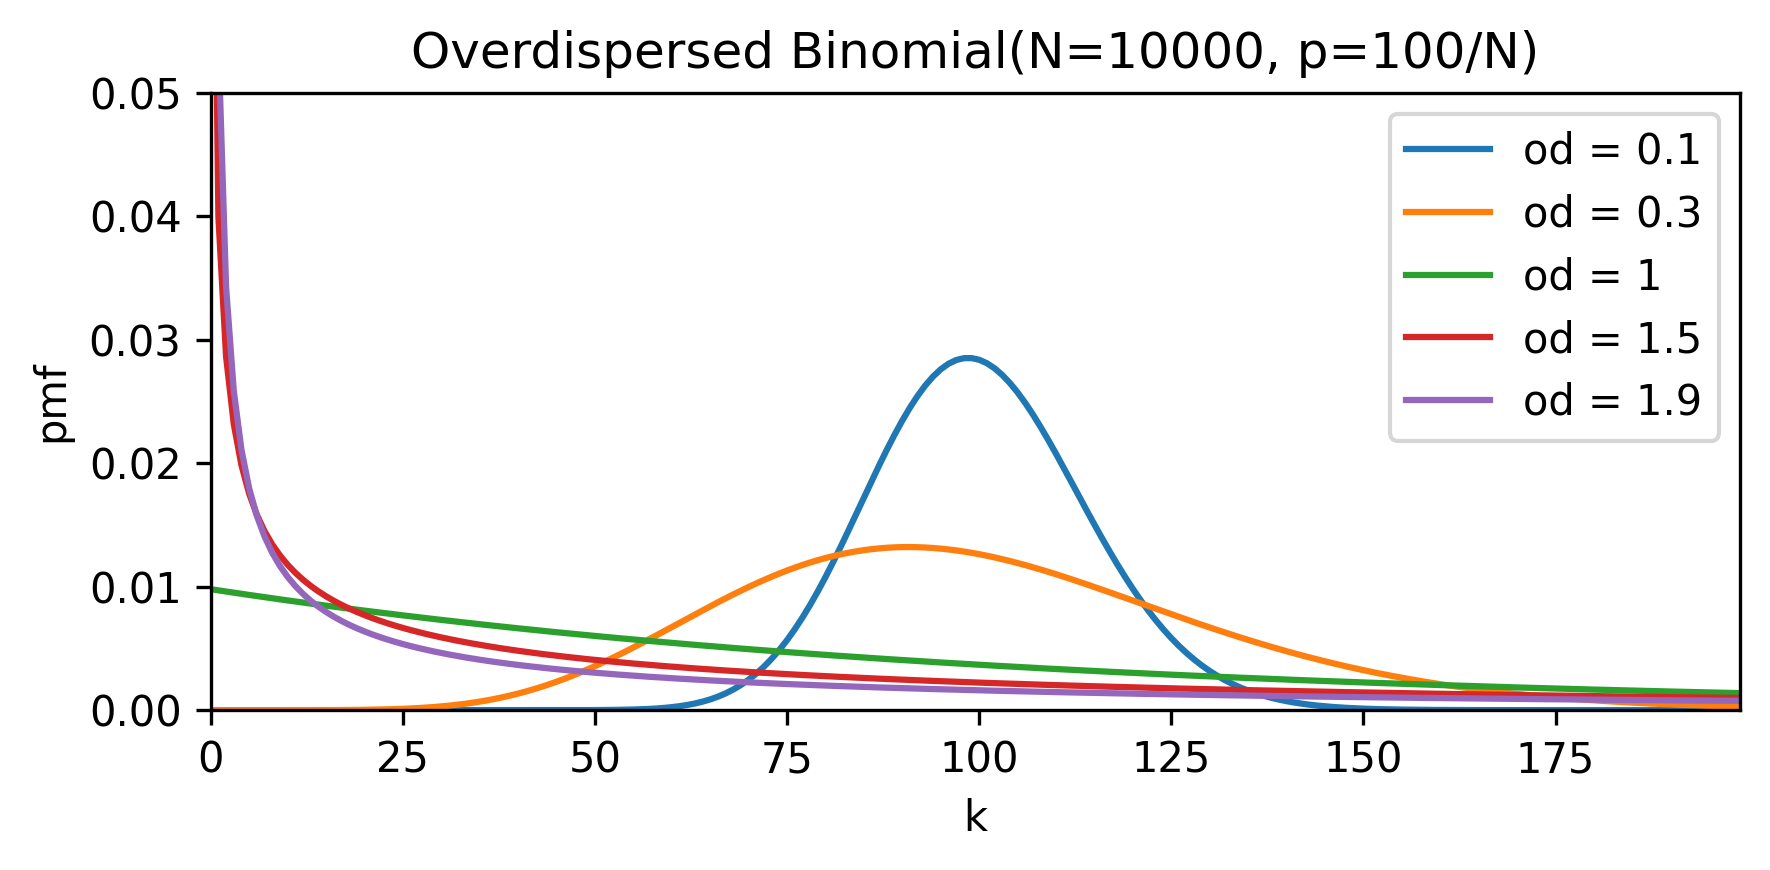

In [8]:
N = 10000.
p = 100. / N
k = torch.arange(200.)
plt.figure(figsize=(6, 3), dpi=300)
for od in [0.1, 0.3, 1.0, 1.5, 1.9]:
    d = binomial_dist(N, p, overdispersion=od)
    plt.plot(k, d.log_prob(k).exp(), label=f"od = {od:0.2g}")
plt.legend(loc="best")
plt.title(f"Overdispersed Binomial(N={int(N)}, p=100/N)")
plt.xlabel("k")
plt.xlim(0, k.max().item())
plt.ylim(0, 0.05)
plt.ylabel("pmf")
plt.tight_layout()

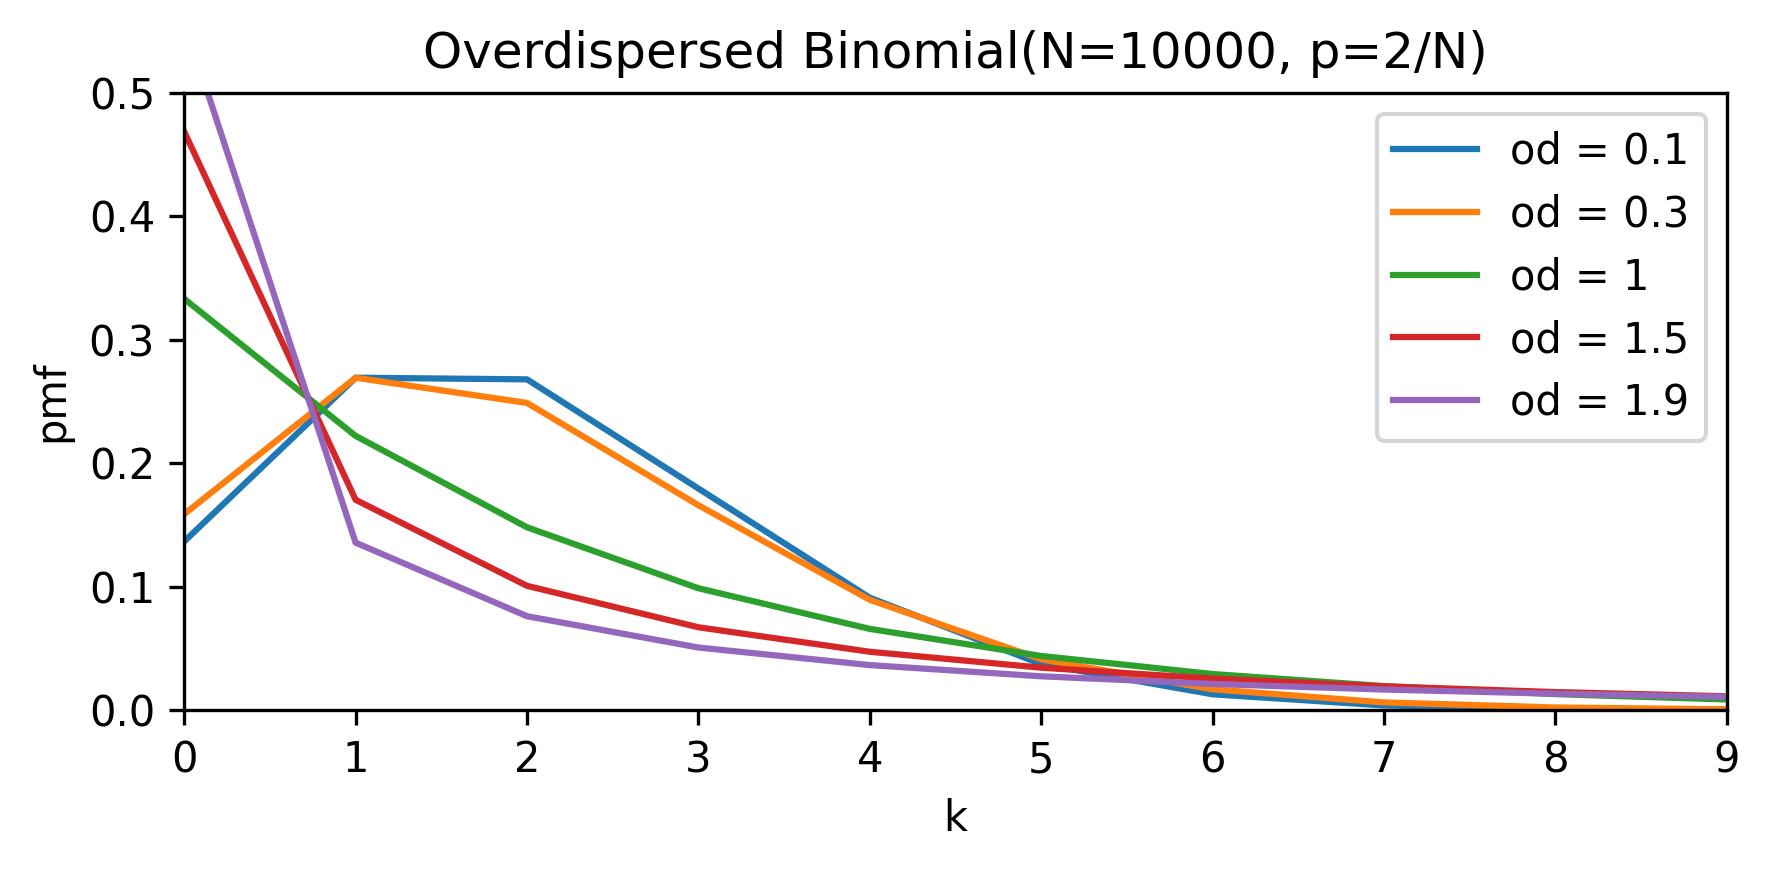

In [9]:
N = 10000.
p = 2. / N
k = torch.arange(10.)
plt.figure(figsize=(6, 3), dpi=300)
for od in [0.1, 0.3, 1.0, 1.5, 1.9]:
    d = binomial_dist(N, p, overdispersion=od)
    plt.plot(k, d.log_prob(k).exp(), label=f"od = {od:0.2g}")
plt.legend(loc="best")
plt.title(f"Overdispersed Binomial(N={int(N)}, p=2/N)")
plt.xlabel("k")
plt.xlim(0, k.max().item())
plt.ylim(0, 0.5)
plt.ylabel("pmf")
plt.tight_layout()